In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from glob import glob

import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter,white_signals,gp_signals,signal_base
from enterprise.signals.utils import powerlaw

from enterprise_extensions import blocks
from enterprise_extensions.model_utils import get_tspan

from la_forge.core import Core

import sys
sys.path.append('../')

from defiant import OptimalStatistic
from defiant import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
datadir = enterprise.__path__[0] + '/datafiles/mdc_open1/'
parfiles = sorted(glob(datadir + '/*.par'))
timfiles = sorted(glob(datadir + '/*.tim'))

psrs = [Pulsar(par,tim) for par,tim in zip(parfiles,timfiles)]

inj_params = {'gw_log10_A':np.log10(5e-14)}

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


In [5]:
Tspan = get_tspan(psrs)

efac = parameter.Constant(1.0)
ef = white_signals.MeasurementNoise(efac=efac)

curn = blocks.common_red_noise_block(psd='powerlaw',Tspan=Tspan,components=10,
                                     gamma_val=13./3.,logmin=-18,logmax=-12,name='gw')

tm = gp_signals.TimingModel(use_svd=True)

model = tm + ef + curn

pta = signal_base.PTA([model(psr) for psr in psrs])

In [6]:
OS_obj = OptimalStatistic(psrs,pta=pta,gwb_name='gw',core_path='../unit_tests/MDC1_FG_CURN_samples.core')

Loading data from HDF5 file....


In [7]:
OS_obj.set_orf(['hd','dipole','monopole'])
xi,rhok,sigk,Ck,Sk,Sks = OS_obj.compute_PFOS(params=inj_params,pair_covariance=True,narrowband=False)
fgw = OS_obj.freqs

100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


In [11]:
xi_range = np.linspace(0.01,np.pi,1000)
hd_mod = utils.orf_xi(xi_range,'hd')

In [ ]:
problem_freq = 4
ORF = OS_obj.orf_design_matrix
data = rhok[problem_freq]
cov = Ck[problem_freq]

/Users/gersbaka/Documents/Projects/defiant/notebooks/../defiant/utils.py:333: RuntimeWarning: invalid value encountered in sqrt
  sigavg[i] = np.abs(bin_orf)*np.sqrt(s2)


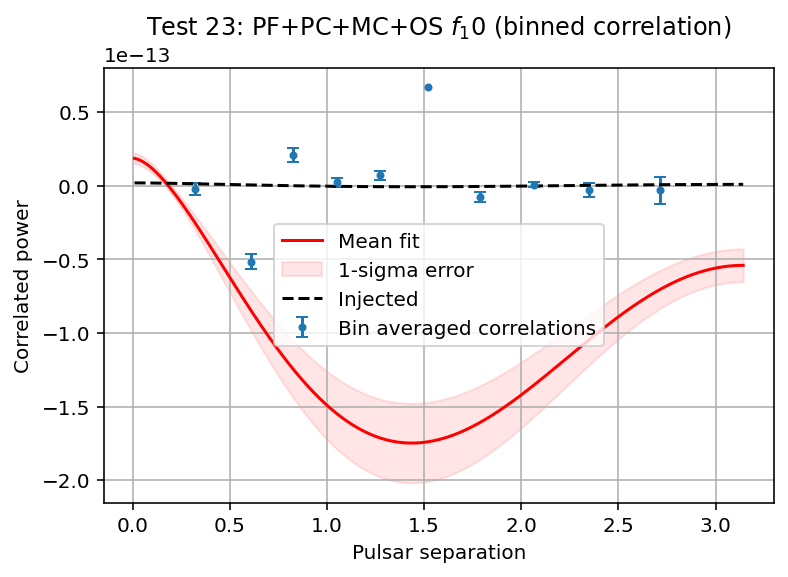

In [13]:
plt.title(f'$f_{k+1}$ binned correlation')
xiBin,rhoBin,sigBin = utils.binned_pair_correlations(xi,rhok[problem_freq],Ck[problem_freq],bins=10,orf='hd')
plt.errorbar(xiBin,rhoBin,sigBin,fmt='.',capsize=3,label='Bin averaged correlations')
clipped = utils.clip_covariance(Sks[problem_freq],1e-32)
mean,mean_sig = utils.calculate_mean_sigma_for_MCOS(xi_range,Sk[problem_freq],clipped,['hd','dipole','monopole'])
plt.plot(xi_range,mean,'-r',label='Mean fit')
plt.fill_between(xi_range,(mean-mean_sig), (mean+mean_sig),color='r',alpha=0.1,label='1-sigma error')

plt.plot(xi_range,inj_pl[problem_freq]*hd_mod,'--k',label='Injected')

plt.xlabel('Pulsar separation')
plt.ylabel('Correlated power')
plt.grid()
plt.legend()
plt.show()